# Lab 3 - Comparing Classification Models



---















# Comment
Using functional api instead of sequential api as using the sequential api would not let me print the input layer to visualise the model after adding the layers (in model.summary())

In this session, we demonstrate how to solve a text classification task using simple 
feedforward neural network classifier. We will use IMDB Large Movie Review Dataset to train a binary classification model, able to predict whether a review is positive or negative. First, our network takes one-hot word vectors as input, averages them to make one vector and trains a 
fully-connected layer to predict the output. In the second part, we replace the one-hot vectors with the word embeddings and add a layer to see how much that improves the performance.

We are going to use Keras Sequential API in this session. The Sequential API allows you to make models layer-by-layer. But it is not straightforward to define models where layers connect to more than just the previous and next layers. 

In [ ]:
import tensorflow.keras as tk
import numpy as np
from keras.layers import Lambda, GlobalAveragePooling1D, Dense, Embedding, Input
from keras import backend as K
from keras.models import Sequential
import matplotlib.pyplot as plt


### Downloading data

The dataset we will be using is the IMDB Large Movie Review Dataset, which consists of 50000 labeled movie reviews. These are split into 25,000 reviews for training and 25,000 reviews for testing. The  dataset contains an even number of positive and negative reviews, so randomly guessing yields 50% accuracy. The data is preprocessed. For text classification, it is ususal to limit the size of the vocabulary to stop the dataset from becoming too sparse, creating possible overfitting. We keep the top 10,000 most frequently occurring words in the training data.


In [ ]:
imdb = tk.datasets.imdb
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=10000)

We now can start playing around with the data, let’s first see the length:

In [ ]:
print("Training entries: {}, labels: {}".format(len(X_train), len(y_train)))

Training entries: 25000, labels: 25000


The  reviews have been converted to integers and each integer represents a  word in a dictionary. 

In [ ]:
 X_train[0][:10]

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]

We can convert integers back to words by querying a dictionary object that contains the integer to string mapping:

In [ ]:
word_index = imdb.get_word_index()

Index 1 represents the beginning of the sentence and the index 2 is assigned to all unknown tokens. Index 0 will be used for padding.

In [ ]:
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  
word_index["<UNUSED>"] = 3

To reverse key and values in a dictionary:

In [ ]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

To view a word:

In [ ]:
reverse_word_index[25]

'you'

And to recreate the whole sentence from our training data we define decode_review:


In [ ]:
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [ ]:
decode_review(X_train[10])

"<START> french horror cinema has seen something of a revival over the last couple of years with great films such as inside and <UNK> romance <UNK> on to the scene <UNK> <UNK> the revival just slightly but stands head and shoulders over most modern horror titles and is surely one of the best french horror films ever made <UNK> was obviously shot on a low budget but this is made up for in far more ways than one by the originality of the film and this in turn is <UNK> by the excellent writing and acting that ensure the film is a winner the plot focuses on two main ideas prison and black magic the central character is a man named <UNK> sent to prison for fraud he is put in a cell with three others the quietly insane <UNK> body building <UNK> marcus and his retarded boyfriend daisy after a short while in the cell together they stumble upon a hiding place in the wall that contains an old <UNK> after <UNK> part of it they soon realise its magical powers and realise they may be able to use it

### Creating One-hot word vectors

It is  common to use one-hot representation as input in Natural Language Processing tasks. In Keras, the Embedding layer takes an index as an input and convert it to one-hot vector with the length of the vocabulary size. Then multiplies these vectors by a normal weight matrix. But there is no way to only get a one-hot vector as the output of a layer in Keras. To solve this we use Lambda() layer and a function that creates the one-hot layer. 

In [ ]:
def OneHot(input_dim=None, input_length=None):
    
    if input_dim is None or input_length is None:
        raise TypeError("input_dim or input_length is not set")

    
    def _one_hot(x, num_classes):
        return K.one_hot(K.cast(x, 'uint8'),
                          num_classes=num_classes)

    return Lambda(_one_hot,
                  arguments={'num_classes': input_dim},
                  input_shape=(input_length,))

input_dim refers to the length of the one-hot vector and input_length refers to the length of the input sequence. Since the input to K.one_hot should be an integer tensor, we cast x to one (Keras passes around float tensors by default).



 Each text sequence has in most cases different length of words. Here, we fill sequences with a pad token (0) to fit the size. This special tokens is then masked not to be accounted in averaging, loss calculation etc. We set the maximum length to 256.

### Preparing input data

In [ ]:
VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 256
import keras
X_train_enc = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

X_test_enc = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

And to view a padded review:

In [ ]:
print(X_train_enc[1])
print('\nLength: ',len(X_train_enc))

[   1  194 1153  194 8255   78  228    5    6 1463 4369 5012  134   26
    4  715    8  118 1634   14  394   20   13  119  954  189  102    5
  207  110 3103   21   14   69  188    8   30   23    7    4  249  126
   93    4  114    9 2300 1523    5  647    4  116    9   35 8163    4
  229    9  340 1322    4  118    9    4  130 4901   19    4 1002    5
   89   29  952   46   37    4  455    9   45   43   38 1543 1905  398
    4 1649   26 6853    5  163   11 3215    2    4 1153    9  194  775
    7 8255    2  349 2637  148  605    2 8003   15  123  125   68    2
 6853   15  349  165 4362   98    5    4  228    9   43    2 1157   15
  299  120    5  120  174   11  220  175  136   50    9 4373  228 8255
    5    2  656  245 2350    5    4 9837  131  152  491   18    2   32
 7464 1212   14    9    6  371   78   22  625   64 1382    9    8  168
  145   23    4 1690   15   16    4 1355    5   28    6   52  154  462
   33   89   78  285   16  145   95    0    0    0    0    0    0    0
    0 

Now we want to build the neural network model. We  are going to have a hidden layer with 16 hidden units. 

First, we want to transform each index to an embedded vector and then average all vectors to a single one. It has been showed that unweighted average of word vectors outperforms many complicated networks that model semantic and syntactic compositionality. As an example you can take a look at this: (http://anthology.aclweb.org/P/P15/P15-1162.pdf)

To average we need to ignore padded zeros:

In [ ]:
class GlobalAveragePooling1DMasked(GlobalAveragePooling1D):
    def call(self, x, mask=None):
        if mask != None:
            return K.sum(x, axis=1) / K.sum(mask, axis=1)
        else:
            return super().call(x)


# Model 1: Neural averaging network using one-hot vectors

The first layer is an one-hot layer. The second layer is to compute average on all word vectors in a sentence without considering padding. The  output vector is piped through a fully-connected layer. The last layer is connected with a single output node with the sigmoid activation function. The final value is a float between 0 and 1. 
The vocabulary count of the movie reviews (10000) is used as the input shape. At the end we visualize the model summary.

In [ ]:
# your code goes here
import tensorflow as tf
from keras.models import Model
# The input is an array of target indices e.g. [2, 45, 7, 23,...9]
input = Input((256,), dtype='int32')
lambdalayer = OneHot(VOCAB_SIZE, MAX_SEQUENCE_LENGTH)(input)
avg_pool = GlobalAveragePooling1D()(lambdalayer) 

dense_layer = tf.keras.layers.Dense(units=16, name="dense_layer")(avg_pool)
output_layer = tf.keras.layers.Dense(units=1, name="dense_layer_output", activation = 'sigmoid')(dense_layer)

model = Model(inputs=[input], outputs=[output_layer])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256)]             0         
                                                                 
 lambda (Lambda)             (None, 256, 10000)        0         
                                                                 
 global_average_pooling1d (G  (None, 10000)            0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_layer (Dense)         (None, 16)                160016    
                                                                 
 dense_layer_output (Dense)  (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_______________________________________________________

### Training the model

To compile the model we need a loss function and an optimizer. We use binary_crossentropy loss function which is just a special case of categorical cross entropy. We also use Adam optimizer that can be used instead of the classical stochastic gradient descent procedure to update network weights iterative based in training data. You can read more about it here:
(https://arxiv.org/abs/1412.6980v8
)


In [ ]:
# your code goes here
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

When training, we want to check the accuracy of the model on data it hasn't seen before. So we create a validation set:

In [ ]:
X_val = np.array(X_train_enc[:10000])
partial_X_train = np.array(X_train_enc[10000:])

y_val = np.array(y_train[:10000])
partial_y_train = np.array(y_train[10000:])

Then we start to train the model for 40 epochs in mini-batches of 512 samples and monitor the model's loss and accuracy on the validation set.

In [ ]:
history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 11s 267ms/step - loss: 0.6923 - accuracy: 0.5133 - val_loss: 0.6912 - val_accuracy: 0.5764
Epoch 2/40
30/30 [==============================] - 8s 258ms/step - loss: 0.6900 - accuracy: 0.5901 - val_loss: 0.6889 - val_accuracy: 0.6379
Epoch 3/40
30/30 [==============================] - 8s 259ms/step - loss: 0.6872 - accuracy: 0.6130 - val_loss: 0.6859 - val_accuracy: 0.6440
Epoch 4/40
30/30 [==============================] - 8s 264ms/step - loss: 0.6835 - accuracy: 0.6626 - val_loss: 0.6821 - val_accuracy: 0.6658
Epoch 5/40
30/30 [==============================] - 8s 260ms/step - loss: 0.6792 - accuracy: 0.6777 - val_loss: 0.6778 - val_accuracy: 0.6736
Epoch 6/40
30/30 [==============================] - 8s 262ms/step - loss: 0.6742 - accuracy: 0.6812 - val_loss: 0.6728 - val_accuracy: 0.6722
Epoch 7/40
30/30 [==============================] - 8s 258ms/step - loss: 0.6687 - accuracy: 0.6839 - val_loss: 0.6674 - val_accuracy: 0.6750
Epoch

### Evaluating the model

To evaulate the model on test data:

In [ ]:
results = model.evaluate(X_test_enc, y_test)

782/782 [==============================] - 10s 13ms/step - loss: 0.5342 - accuracy: 0.7426


In [ ]:
print(results)
# loss, accuracay 

[0.5341730713844299, 0.7426000237464905]


Our first model accuracy using one-hot vectors is ~74%







### Plotting the accuracy graph

In [ ]:
!pip install plot_keras_history
from plot_keras_history import plot_history
import matplotlib.pyplot as plt

  Created wheel for plot-keras-history: filename=plot_keras_history-1.1.30-py3-none-any.whl size=8794 sha256=39adf38cac3f37c6405a4715c4c2d981ed143cb637021150783468a662d388aa
  Stored in directory: /root/.cache/pip/wheels/b0/60/47/8c5aa37c06be5e97879ec467bc2e6a30b315d95f662c63a503
  Created wheel for sanitize-ml-labels: filename=sanitize_ml_labels-1.0.29-py3-none-any.whl size=7878 sha256=5690c3f0c5000c654ab3a86c8474a7d4423703755529e2da3953a84dfd50dc85
  Stored in directory: /root/.cache/pip/wheels/c2/f5/71/d1c459da10abec864a1979b449edbf37d4a82ab3e38a3625a8
  Created wheel for compress-json: filename=compress_json-1.0.4-py3-none-any.whl size=4588 sha256=8f01f9b8eab66c827e0e077daca3af3acf2477dd994e9ab01e07614d5b53265d
  Stored in directory: /root/.cache/pip/wheels/1e/ef/1e/5d403c5632b0462471a8d26049d0c138134d0255ec60ce4c14
Successfully built plot-keras-history sanitize-ml-labels compress-json


To plot a graph of accuracy and loss over time we can use Matplotlib:

  Created wheel for plot-keras-history: filename=plot_keras_history-1.1.30-py3-none-any.whl size=8794 sha256=3006a31106d36b4d1732f2265e745cd25f2ed5b85e3c7343e83a565060f44ffa
  Stored in directory: /root/.cache/pip/wheels/b0/60/47/8c5aa37c06be5e97879ec467bc2e6a30b315d95f662c63a503
  Created wheel for sanitize-ml-labels: filename=sanitize_ml_labels-1.0.29-py3-none-any.whl size=7878 sha256=dfe198befb21b833e41a8d9bde1707b209aa8c76653193bbc154428be06462cc
  Stored in directory: /root/.cache/pip/wheels/c2/f5/71/d1c459da10abec864a1979b449edbf37d4a82ab3e38a3625a8
  Created wheel for compress-json: filename=compress_json-1.0.4-py3-none-any.whl size=4588 sha256=896450bc72ae905018d59aab7f6603a6cbb88aa75856d58835ccbd55ac568e95
  Stored in directory: /root/.cache/pip/wheels/1e/ef/1e/5d403c5632b0462471a8d26049d0c138134d0255ec60ce4c14
Successfully built plot-keras-history sanitize-ml-labels compress-json


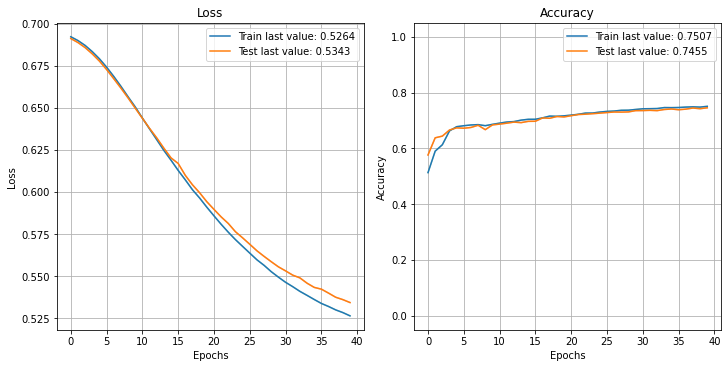

In [ ]:
# your code goes here
!pip install plot_keras_history
from plot_keras_history import plot_history
import matplotlib.pyplot as plt
plot_history(history.history, path="standard.png")
plt.show()

# Model 2: Neural averaging network using embedding layer

Now instead of one-hot vectors, we want to use embedding. We change our first layer in model1 to an Embedding layer. This layer takes the integer-encoded vocabulary and looks up the embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: (batch, sequence, embedding).

In [ ]:
# your code goes here
from keras.models import Model
# The input is an array of target indices e.g. [2, 45, 7, 23,...9]
input = Input((256,), dtype='int32')
embedding = Embedding(VOCAB_SIZE, 16, name='target_embed_layer',
                        	embeddings_initializer='glorot_uniform',
                         	input_length=500, mask_zero=True)(input)
avg_pool = GlobalAveragePooling1D()(embedding) 

dense_layer = tf.keras.layers.Dense(units=16, name="dense_layer")(avg_pool)
output_layer = tf.keras.layers.Dense(units=1, name="dense_layer_output", activation = 'sigmoid')(dense_layer)

model2 = Model(inputs=[input], outputs=[output_layer])
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256)]             0         
                                                                 
 target_embed_layer (Embeddi  (None, 256, 16)          160000    
 ng)                                                             
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_layer (Dense)         (None, 16)                272       
                                                                 
 dense_layer_output (Dense)  (None, 1)                 17        
                                                                 
Total params: 160,289
Trainable params: 160,289
Non-trainab

In [ ]:
history = model2.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 2s 17ms/step - loss: 0.6909 - accuracy: 0.5436 - val_loss: 0.6872 - val_accuracy: 0.7400
Epoch 2/40
30/30 [==============================] - 0s 11ms/step - loss: 0.6797 - accuracy: 0.7590 - val_loss: 0.6712 - val_accuracy: 0.7469
Epoch 3/40
30/30 [==============================] - 0s 15ms/step - loss: 0.6545 - accuracy: 0.7687 - val_loss: 0.6392 - val_accuracy: 0.7611
Epoch 4/40
30/30 [==============================] - 0s 15ms/step - loss: 0.6116 - accuracy: 0.7824 - val_loss: 0.5926 - val_accuracy: 0.7777
Epoch 5/40
30/30 [==============================] - 0s 11ms/step - loss: 0.5553 - accuracy: 0.8026 - val_loss: 0.5378 - val_accuracy: 0.7923
Epoch 6/40
30/30 [==============================] - 0s 12ms/step - loss: 0.4942 - accuracy: 0.8277 - val_loss: 0.4834 - val_accuracy: 0.8175
Epoch 7/40
30/30 [==============================] - 0s 11ms/step - loss: 0.4370 - accuracy: 0.8484 - val_loss: 0.4361 - val_accuracy: 0.8353
Epoch 8/40
30

In [ ]:
results = model2.evaluate(X_test_enc, y_test)

782/782 [==============================] - 3s 3ms/step - loss: 0.3889 - accuracy: 0.8633


In [ ]:
print (results)

[0.38885942101478577, 0.863319993019104]


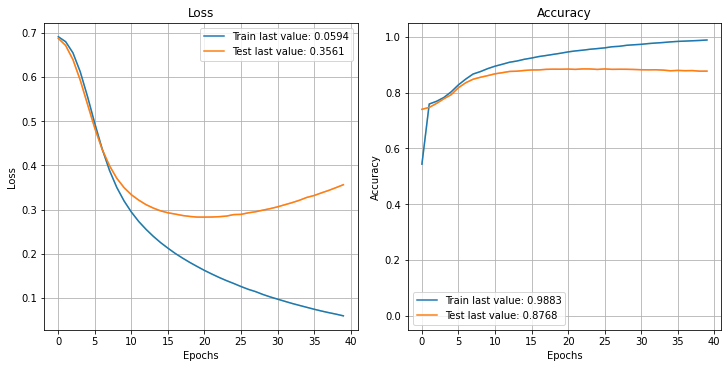

In [ ]:
plot_history(history.history, path="standard.png")
plt.show()

The accuracy of model2 is 87%. Using Embedding layer instead of one-hot layer improved the performance.

# Model 3: Using pre-trained word embeddings

### Preparing pre-trained word embeddings (GLOVE)

The Embedding layer can be used to load a pre-trained word embedding model. We are going to use GloVe embeddings, which you can read about it here (https://nlp.stanford.edu/projects/glove/). GloVe stands for "Global Vectors for Word Representation". It's a somewhat popular embedding technique based on factorizing a matrix of word co-occurence statistics. You can download GloVe and we can seed the Keras Embedding layer with weights from the pre-trained embedding for the words in your dataset.
First, we need to read GloVe and map words to GloVe:


In [ ]:
def readGloveFile(gloveFile):
    with open(gloveFile, 'r') as f:
        wordToGlove = {}  
        wordToIndex = {}  
        indexToWord = {}  

        for line in f:
            record = line.strip().split()
            token = record[0] 
            wordToGlove[token] = np.array(record[1:], dtype=np.float64) 
            
        tokens = sorted(wordToGlove.keys())
        for idx, tok in enumerate(tokens):
            kerasIdx = idx + 1  
            wordToIndex[tok] = kerasIdx 
            indexToWord[kerasIdx] = tok 

    return wordToIndex, indexToWord, wordToGlove

Now, we create our pre-trained Embedding layer:

In [ ]:
from keras.initializers import Constant

def createPretrainedEmbeddingLayer(wordToGlove, wordToIndex, isTrainable):
    vocabLen = len(wordToIndex) + 1  
    embDim = next(iter(wordToGlove.values())).shape[0]  
   
    embeddingMatrix = np.zeros((vocabLen, embDim))  
    for word, index in wordToIndex.items():
        embeddingMatrix[index, :] = wordToGlove[word] 

    embeddingLayer = Embedding(vocabLen, embDim, embeddings_initializer=Constant(embeddingMatrix), trainable=isTrainable, name='GloVe_Embeddings')
    return embeddingLayer

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip '/content/glove.6B.zip'

--2022-03-08 15:58:25--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-03-08 15:58:25--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-03-08 15:58:25--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

We freeze the weights. To create the model: 

In [ ]:
# wordToIndex,indexToWord,wordToGlove=readGloveFile('/content/glove.6B.50d.txt')
# wordToIndex,indexToWord,wordToGlove=readGloveFile('/content/glove.6B.100d.txt')
wordToIndex,indexToWord,wordToGlove=readGloveFile('/content/glove.6B.300d.txt')

# vocabLen = len(wordToIndex) + 1 

EMBED_SIZE = next(iter(wordToGlove.values())).shape[0]
print('Size of Embedding: ',EMBED_SIZE)

embeddingLayer=createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=False)

Size of Embedding:  300


## Model 3-1: Neural bag of words using pre-trained word embeddings

Now we change our model to use GloVe:

In [ ]:
# Inspect model performance with 1 hidden layer, pre-trained embeddings
# your code goes here

# your code goes here
from keras.models import Model
# The input is an array of target indices e.g. [2, 45, 7, 23,...9]
input = Input((256,), dtype='int32')
embedding = embeddingLayer(input)
avg_pool = GlobalAveragePooling1D()(embedding) 

dense_layer = tf.keras.layers.Dense(units=16, name="dense_layer")(avg_pool)
output_layer = tf.keras.layers.Dense(units=1, name="dense_layer_output", activation = 'sigmoid')(dense_layer)

model3 = Model(inputs=[input], outputs=[output_layer])
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model3.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256)]             0         
                                                                 
 GloVe_Embeddings (Embedding  (None, 256, 300)         120000300 
 )                                                               
                                                                 
 global_average_pooling1d_2   (None, 300)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_layer (Dense)         (None, 16)                4816      
                                                                 
 dense_layer_output (Dense)  (None, 1)                 17        
                                                                 
Total params: 120,005,133
Trainable params: 4,833
Non-train

In [ ]:
# Train and test the model

history = model3.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 1s 17ms/step - loss: 0.6911 - accuracy: 0.5317 - val_loss: 0.6836 - val_accuracy: 0.5833
Epoch 2/40
30/30 [==============================] - 0s 11ms/step - loss: 0.6790 - accuracy: 0.5907 - val_loss: 0.6757 - val_accuracy: 0.5827
Epoch 3/40
30/30 [==============================] - 0s 12ms/step - loss: 0.6707 - accuracy: 0.5998 - val_loss: 0.6690 - val_accuracy: 0.6030
Epoch 4/40
30/30 [==============================] - 0s 13ms/step - loss: 0.6629 - accuracy: 0.6120 - val_loss: 0.6611 - val_accuracy: 0.6119
Epoch 5/40
30/30 [==============================] - 0s 11ms/step - loss: 0.6553 - accuracy: 0.6265 - val_loss: 0.6537 - val_accuracy: 0.6266
Epoch 6/40
30/30 [==============================] - 0s 12ms/step - loss: 0.6477 - accuracy: 0.6405 - val_loss: 0.6468 - val_accuracy: 0.6429
Epoch 7/40
30/30 [==============================] - 0s 12ms/step - loss: 0.6390 - accuracy: 0.6533 - val_loss: 0.6392 - val_accuracy: 0.6535
Epoch 8/40
30

In [ ]:
results = model3.evaluate(X_test_enc, y_test)

782/782 [==============================] - 2s 3ms/step - loss: 0.5546 - accuracy: 0.7188


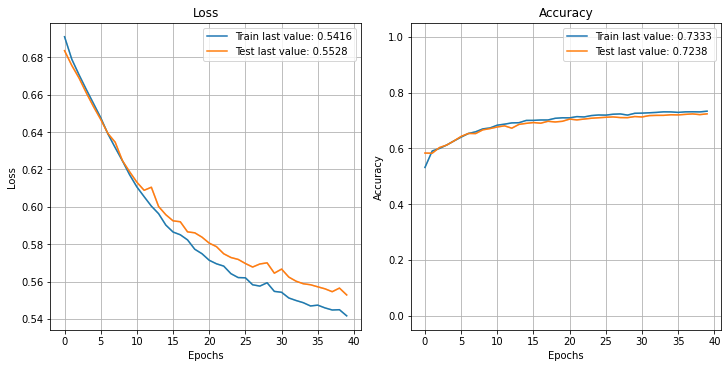

In [ ]:
plot_history(history.history, path="standard.png")
plt.show()

After Freezing the weights


In [ ]:
embeddingLayer_1=createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=True)

In [ ]:
# Inspect model performance with 1 hidden layer, pre-trained embeddings
# your code goes here

# your code goes here
from keras.models import Model
# The input is an array of target indices e.g. [2, 45, 7, 23,...9]
input = Input((256,), dtype='int32')
embedding = embeddingLayer_1(input)
avg_pool = GlobalAveragePooling1D()(embedding) 

dense_layer = tf.keras.layers.Dense(units=16, name="dense_layer")(avg_pool)
output_layer = tf.keras.layers.Dense(units=1, name="dense_layer_output", activation = 'sigmoid')(dense_layer)

model3_2 = Model(inputs=[input], outputs=[output_layer])
model3_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model3_2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256)]             0         
                                                                 
 GloVe_Embeddings (Embedding  (None, 256, 300)         120000300 
 )                                                               
                                                                 
 global_average_pooling1d_3   (None, 300)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_layer (Dense)         (None, 16)                4816      
                                                                 
 dense_layer_output (Dense)  (None, 1)                 17        
                                                                 
Total params: 120,005,133
Trainable params: 120,005,133
Non

In [ ]:
# Train and test the model

history = model3_2.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 4s 114ms/step - loss: 0.6815 - accuracy: 0.5703 - val_loss: 0.6660 - val_accuracy: 0.6302
Epoch 2/40
30/30 [==============================] - 3s 108ms/step - loss: 0.6444 - accuracy: 0.6673 - val_loss: 0.6226 - val_accuracy: 0.6936
Epoch 3/40
30/30 [==============================] - 3s 109ms/step - loss: 0.5843 - accuracy: 0.7383 - val_loss: 0.5537 - val_accuracy: 0.7644
Epoch 4/40
30/30 [==============================] - 3s 110ms/step - loss: 0.5001 - accuracy: 0.8009 - val_loss: 0.4729 - val_accuracy: 0.8115
Epoch 5/40
30/30 [==============================] - 3s 110ms/step - loss: 0.4156 - accuracy: 0.8469 - val_loss: 0.4061 - val_accuracy: 0.8419
Epoch 6/40
30/30 [==============================] - 3s 108ms/step - loss: 0.3500 - accuracy: 0.8707 - val_loss: 0.3625 - val_accuracy: 0.8570
Epoch 7/40
30/30 [==============================] - 3s 110ms/step - loss: 0.3033 - accuracy: 0.8885 - val_loss: 0.3339 - val_accuracy: 0.8684
Epoch 

In [ ]:
results = model3_2.evaluate(X_test_enc, y_test)

782/782 [==============================] - 2s 3ms/step - loss: 0.6096 - accuracy: 0.8522


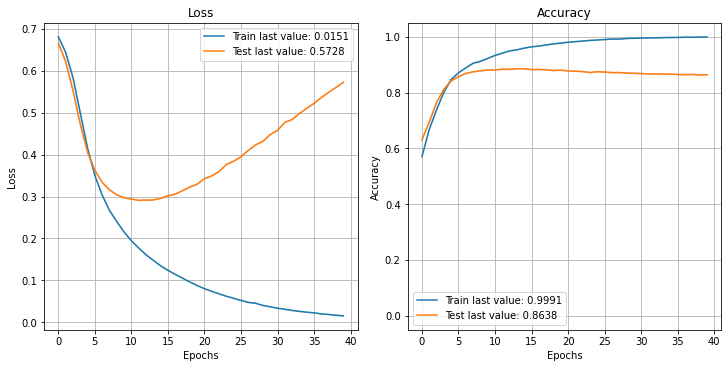

In [ ]:
plot_history(history.history, path="standard.png")
plt.show()

To compare freezing and fine-tuning the pre-train embedding weights, we fine-tune the weights here:

Experiments here show that fine-tuning the pre-trained embeddings would obtain better accuracy.

Note that although fine-tuning the pre-trained embeddings is better here, we do not fine-tune it in other models. You could conduct extra experiments to compare the results.

##  Model 3-2: LSTM with pre-trained word embeddings

In previous labs, we have conducted an experiment based on LSTM. Now, we replace its embeddings with the GloVe pre-trained embeddings.

In [ ]:
# your code goes here
from keras.models import Model
# The input is an array of target indices e.g. [2, 45, 7, 23,...9]
input = Input((256,), dtype='int32')
embedding = embeddingLayer(input)
lstm = tf.keras.layers.LSTM(100)(embedding)

output_layer = tf.keras.layers.Dense(units=1, name="dense_layer_output", activation = 'sigmoid')(lstm)

model7 = Model(inputs=[input], outputs=[output_layer])
model7.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model7.summary()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 256)]             0         
                                                                 
 GloVe_Embeddings (Embedding  (None, 256, 300)         120000300 
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense_layer_output (Dense)  (None, 1)                 101       
                                                                 
Total params: 120,160,801
Trainable params: 160,501
Non-trainable params: 120,000,300
_________________________________________________________________


In [ ]:
# Train and test the model

history = model7.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 10s 189ms/step - loss: 0.6909 - accuracy: 0.5151 - val_loss: 0.6847 - val_accuracy: 0.5290
Epoch 2/40
30/30 [==============================] - 5s 166ms/step - loss: 0.6667 - accuracy: 0.5763 - val_loss: 0.6332 - val_accuracy: 0.6491
Epoch 3/40
30/30 [==============================] - 5s 168ms/step - loss: 0.6342 - accuracy: 0.6552 - val_loss: 0.6207 - val_accuracy: 0.6703
Epoch 4/40
30/30 [==============================] - 5s 173ms/step - loss: 0.6226 - accuracy: 0.6736 - val_loss: 0.6213 - val_accuracy: 0.6716
Epoch 5/40
30/30 [==============================] - 5s 167ms/step - loss: 0.6314 - accuracy: 0.6600 - val_loss: 0.6742 - val_accuracy: 0.6165
Epoch 6/40
30/30 [==============================] - 5s 166ms/step - loss: 0.6425 - accuracy: 0.6436 - val_loss: 0.6281 - val_accuracy: 0.6669
Epoch 7/40
30/30 [==============================] - 5s 167ms/step - loss: 0.6174 - accuracy: 0.6720 - val_loss: 0.6311 - val_accuracy: 0.6639
Epoch

In [ ]:
# Train and test the model

results = model7.evaluate(X_test_enc, y_test)

782/782 [==============================] - 16s 21ms/step - loss: 0.6896 - accuracy: 0.5346


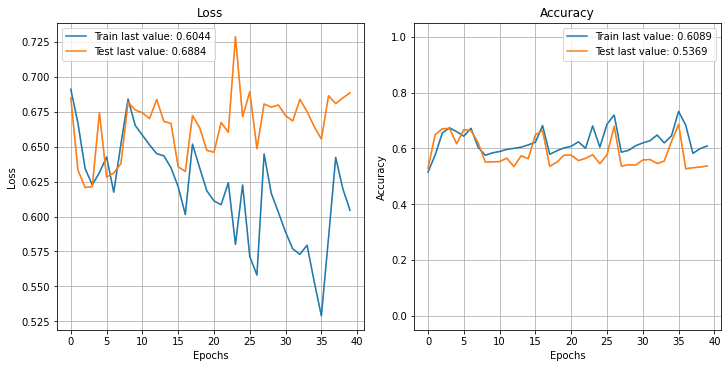

In [ ]:
plot_history(history.history, path="standard.png")
plt.show()

Experiment show that simply replacing the lab 2 model embeddings with pre-trained word embeddings (GloVe) will cause performance to drop significantly. 
What can you do to improve the situation?

To improve the model performace we will set the trainable parameter in the embedding layer to true instead of false. By this we enable our model to train rather than use the pre-trained word embeddings.

In [ ]:
# your code goes here
from keras.models import Model
import tensorflow as tf
# The input is an array of target indices e.g. [2, 45, 7, 23,...9]
input = Input((256,), dtype='int32')
embedding = embeddingLayer_1(input)
lstm = tf.keras.layers.LSTM(100)(embedding)

output_layer = tf.keras.layers.Dense(units=1, name="dense_layer_output", activation = 'sigmoid')(lstm)

model71 = Model(inputs=[input], outputs=[output_layer])
model71.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model71.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256)]             0         
                                                                 
 GloVe_Embeddings (Embedding  (None, 256, 300)         120000300 
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense_layer_output (Dense)  (None, 1)                 101       
                                                                 
Total params: 120,160,801
Trainable params: 120,160,801
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model71.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 18s 379ms/step - loss: 0.6882 - accuracy: 0.5189 - val_loss: 0.6799 - val_accuracy: 0.5425
Epoch 2/40
30/30 [==============================] - 11s 361ms/step - loss: 0.6531 - accuracy: 0.5950 - val_loss: 0.6457 - val_accuracy: 0.6044
Epoch 3/40
30/30 [==============================] - 11s 361ms/step - loss: 0.5947 - accuracy: 0.6984 - val_loss: 0.5264 - val_accuracy: 0.7654
Epoch 4/40
30/30 [==============================] - 11s 361ms/step - loss: 0.7294 - accuracy: 0.5527 - val_loss: 0.6786 - val_accuracy: 0.5333
Epoch 5/40
30/30 [==============================] - 11s 364ms/step - loss: 0.6576 - accuracy: 0.5779 - val_loss: 0.6691 - val_accuracy: 0.5493
Epoch 6/40
30/30 [==============================] - 11s 363ms/step - loss: 0.6345 - accuracy: 0.5992 - val_loss: 0.6511 - val_accuracy: 0.5720
Epoch 7/40
30/30 [==============================] - 11s 366ms/step - loss: 0.5784 - accuracy: 0.6843 - val_loss: 0.6118 - val_accuracy: 0.6726

In [ ]:
results = model71.evaluate(X_test_enc, y_test)

782/782 [==============================] - 17s 21ms/step - loss: 0.6522 - accuracy: 0.7903


It is clearly evident that after setting the trainable parameter = True, the model validation accuracy has increased by a significant amount. The accuracy previously using the pre-trained glove word embeddings was 53.46% which increased to 79.03% just like the model 3-1.

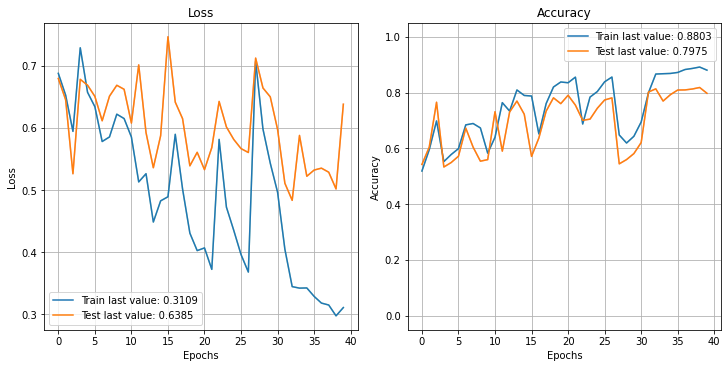

In [ ]:
plot_history(history.history, path="standard.png")
plt.show()

#  Model 4: Adding extra dense layer into Neural averaging network model

We add extra dense layers into model 3-1 (neural network model) to evaluate extra dense layers' contribution. We start by adding one layer, then add two. All parameters are the same as model 3-1.

### Adding one extra dense layer

In [ ]:
# Inspect model performance with 1 hidden layer, pre-trained embeddings
# your code goes here

from keras.models import Model
# The input is an array of target indices e.g. [2, 45, 7, 23,...9]
input = Input((256,), dtype='int32')
embedding = embeddingLayer(input)
avg_pool = GlobalAveragePooling1D()(embedding) 
extra_dense = tf.keras.layers.Dense(units=100, name="extra_dense_layer")(avg_pool)
dense_layer = tf.keras.layers.Dense(units=16, name="dense_layer")(extra_dense)
output_layer = tf.keras.layers.Dense(units=1, name="dense_layer_output", activation = 'sigmoid')(dense_layer)

model4 = Model(inputs=[input], outputs=[output_layer])
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model4.summary()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 256)]             0         
                                                                 
 GloVe_Embeddings (Embedding  (None, 256, 300)         120000300 
 )                                                               
                                                                 
 global_average_pooling1d_2   (None, 300)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 extra_dense_layer (Dense)   (None, 100)               30100     
                                                                 
 dense_layer (Dense)         (None, 16)                1616      
                                                                 
 dense_layer_output (Dense)  (None, 1)                 17  

In [ ]:
# Train and test the model

history = model4.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 1s 20ms/step - loss: 0.6800 - accuracy: 0.5673 - val_loss: 0.6735 - val_accuracy: 0.5752
Epoch 2/40
30/30 [==============================] - 0s 13ms/step - loss: 0.6622 - accuracy: 0.6066 - val_loss: 0.6614 - val_accuracy: 0.6017
Epoch 3/40
30/30 [==============================] - 0s 13ms/step - loss: 0.6387 - accuracy: 0.6520 - val_loss: 0.6309 - val_accuracy: 0.6536
Epoch 4/40
30/30 [==============================] - 0s 13ms/step - loss: 0.6137 - accuracy: 0.6764 - val_loss: 0.6077 - val_accuracy: 0.6759
Epoch 5/40
30/30 [==============================] - 0s 13ms/step - loss: 0.5909 - accuracy: 0.6935 - val_loss: 0.6115 - val_accuracy: 0.6686
Epoch 6/40
30/30 [==============================] - 0s 14ms/step - loss: 0.5887 - accuracy: 0.6911 - val_loss: 0.5833 - val_accuracy: 0.6987
Epoch 7/40
30/30 [==============================] - 0s 13ms/step - loss: 0.5684 - accuracy: 0.7118 - val_loss: 0.5760 - val_accuracy: 0.7045
Epoch 8/40
30

In [ ]:
results = model4.evaluate(X_test_enc, y_test)

782/782 [==============================] - 2s 3ms/step - loss: 0.5335 - accuracy: 0.7344


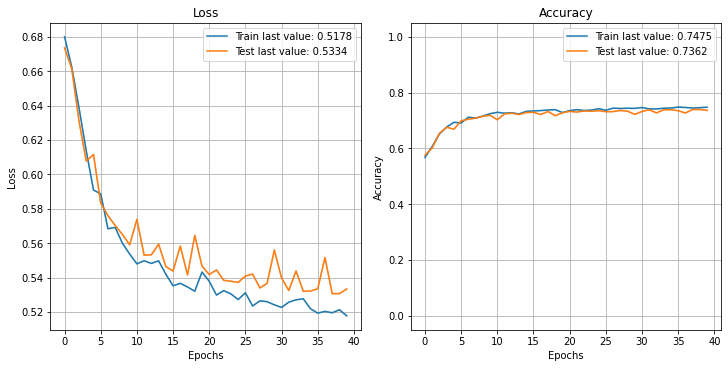

In [ ]:
plot_history(history.history, path="standard.png")
plt.show()

### Adding two extra dense layers

In [ ]:
# Inspect model performance with 1 hidden layer, pre-trained embeddings
# your code goes here

from keras.models import Model
# The input is an array of target indices e.g. [2, 45, 7, 23,...9]
input = Input((256,), dtype='int32')
embedding = embeddingLayer(input)
avg_pool = GlobalAveragePooling1D()(embedding) 
extra_dense = tf.keras.layers.Dense(units=300, name="extra_dense_layer")(avg_pool)
extra_dense_2 = tf.keras.layers.Dense(units=100, name="extra_dense_layer_2")(extra_dense)
dense_layer = tf.keras.layers.Dense(units=16, name="dense_layer")(extra_dense_2)
output_layer = tf.keras.layers.Dense(units=1, name="dense_layer_output", activation = 'sigmoid')(dense_layer)

model4_2 = Model(inputs=[input], outputs=[output_layer])
model4_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model4_2.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 256)]             0         
                                                                 
 GloVe_Embeddings (Embedding  (None, 256, 300)         120000300 
 )                                                               
                                                                 
 global_average_pooling1d_3   (None, 300)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 extra_dense_layer (Dense)   (None, 300)               90300     
                                                                 
 extra_dense_layer_2 (Dense)  (None, 100)              30100     
                                                                 
 dense_layer (Dense)         (None, 16)                1616

In [ ]:
# Train and test the model

history = model4_2.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 1s 19ms/step - loss: 0.6819 - accuracy: 0.5639 - val_loss: 0.6709 - val_accuracy: 0.5804
Epoch 2/40
30/30 [==============================] - 0s 13ms/step - loss: 0.6416 - accuracy: 0.6409 - val_loss: 0.6165 - val_accuracy: 0.6653
Epoch 3/40
30/30 [==============================] - 0s 13ms/step - loss: 0.6080 - accuracy: 0.6735 - val_loss: 0.6090 - val_accuracy: 0.6677
Epoch 4/40
30/30 [==============================] - 0s 13ms/step - loss: 0.5815 - accuracy: 0.6994 - val_loss: 0.5767 - val_accuracy: 0.7030
Epoch 5/40
30/30 [==============================] - 0s 13ms/step - loss: 0.5622 - accuracy: 0.7178 - val_loss: 0.5776 - val_accuracy: 0.7081
Epoch 6/40
30/30 [==============================] - 0s 13ms/step - loss: 0.5733 - accuracy: 0.7021 - val_loss: 0.5637 - val_accuracy: 0.7137
Epoch 7/40
30/30 [==============================] - 0s 14ms/step - loss: 0.5589 - accuracy: 0.7187 - val_loss: 0.5651 - val_accuracy: 0.7119
Epoch 8/40
30

In [ ]:
results = model4_2.evaluate(X_test_enc, y_test)

782/782 [==============================] - 2s 3ms/step - loss: 0.5353 - accuracy: 0.7329


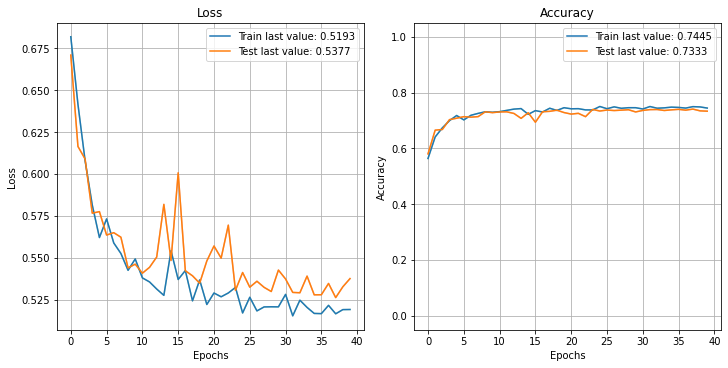

In [ ]:
plot_history(history.history, path="standard.png")
plt.show()

These two experiments show that adding extra dense layers can slightly improve accuracy over model 3-1.

---



#  Model 5: CNN for Text Classification

In this section, we build a Convolutional Neural Network (CNN) for text classification. We start by using one CNN layer and then adding another layer. You could use embeddings from pre-trained or scratch.

##  Model 5-1: Basic CNN model for Text Classification 

In [ ]:
from keras.layers.pooling import GlobalMaxPooling1D
hidden_layer=16

from keras.models import Model

input = Input((256,), dtype='int32')
embedding = Embedding(VOCAB_SIZE, 300, name='embed_layer',
                        	embeddings_initializer='glorot_uniform',
                         	input_length=500, mask_zero=True)(input)
conv = tf.keras.layers.Conv1D(100,6)(embedding)
pool = GlobalMaxPooling1D()(conv)
output_layer = tf.keras.layers.Dense(units=1, name="dense_layer_output", activation = 'sigmoid')(pool)

model5_1 = Model(inputs=[input], outputs=[output_layer])
model5_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model5_1.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 256)]             0         
                                                                 
 embed_layer (Embedding)     (None, 256, 300)          3000000   
                                                                 
 conv1d (Conv1D)             (None, 251, 100)          180100    
                                                                 
 global_max_pooling1d (Globa  (None, 100)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_layer_output (Dense)  (None, 1)                 101       
                                                                 
Total params: 3,180,201
Trainable params: 3,180,201
Non-trainable params: 0
_________________________________________________

In [ ]:
# Train and test the model
# Train and test the model
history = model5_1.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)
# your code goes here
results = model5_1.evaluate(X_test_enc, y_test)

Epoch 1/40
30/30 [==============================] - 12s 149ms/step - loss: 0.6627 - accuracy: 0.6948 - val_loss: 0.5894 - val_accuracy: 0.7869
Epoch 2/40
30/30 [==============================] - 4s 121ms/step - loss: 0.4625 - accuracy: 0.8269 - val_loss: 0.3625 - val_accuracy: 0.8483
Epoch 3/40
30/30 [==============================] - 4s 122ms/step - loss: 0.2742 - accuracy: 0.8959 - val_loss: 0.3055 - val_accuracy: 0.8681
Epoch 4/40
30/30 [==============================] - 4s 129ms/step - loss: 0.1716 - accuracy: 0.9455 - val_loss: 0.3007 - val_accuracy: 0.8745
Epoch 5/40
30/30 [==============================] - 4s 122ms/step - loss: 0.1025 - accuracy: 0.9751 - val_loss: 0.3174 - val_accuracy: 0.8701
Epoch 6/40
30/30 [==============================] - 4s 128ms/step - loss: 0.0564 - accuracy: 0.9900 - val_loss: 0.3454 - val_accuracy: 0.8689
Epoch 7/40
30/30 [==============================] - 4s 129ms/step - loss: 0.0306 - accuracy: 0.9968 - val_loss: 0.3761 - val_accuracy: 0.8665
Epoch

In [ ]:
results = model5_1.evaluate(X_test_enc, y_test)

782/782 [==============================] - 5s 6ms/step - loss: 0.7060 - accuracy: 0.8490


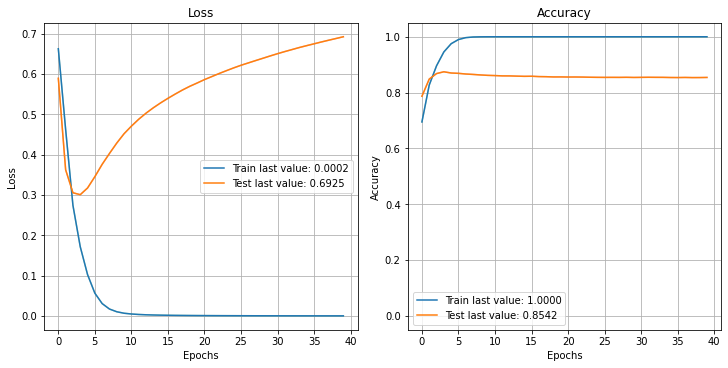

In [ ]:
# your code goes here
plot_history(history.history, path="standard.png")
plt.show()


## Model 5-2: Adding extra convolutional layer

In [ ]:
# your code goes here

from keras.layers.pooling import GlobalMaxPooling1D
hidden_layer=16

from keras.models import Model

input = Input((256,), dtype='int32')
embedding = Embedding(VOCAB_SIZE, 300, name='embed_layer',
                        	embeddings_initializer='glorot_uniform',
                         	input_length=500, mask_zero=True)(input)
conv = tf.keras.layers.Conv1D(100,6)(embedding)
conv2 = tf.keras.layers.Conv1D(100,6)(conv)
pool = GlobalMaxPooling1D()(conv2)
output_layer = tf.keras.layers.Dense(units=1, name="dense_layer_output", activation = 'sigmoid')(pool)

model5_2 = Model(inputs=[input], outputs=[output_layer])
model5_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model5_2.summary()


Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 256)]             0         
                                                                 
 embed_layer (Embedding)     (None, 256, 300)          3000000   
                                                                 
 conv1d_1 (Conv1D)           (None, 251, 100)          180100    
                                                                 
 conv1d_2 (Conv1D)           (None, 246, 100)          60100     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 100)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_layer_output (Dense)  (None, 1)                 101       
                                                           

In [ ]:
# Train and test the model
# Train and test the model

history = model5_2.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)


Epoch 1/40
30/30 [==============================] - 17s 291ms/step - loss: 0.6218 - accuracy: 0.6701 - val_loss: 0.4280 - val_accuracy: 0.8011
Epoch 2/40
30/30 [==============================] - 7s 220ms/step - loss: 0.3586 - accuracy: 0.8461 - val_loss: 0.3608 - val_accuracy: 0.8427
Epoch 3/40
30/30 [==============================] - 7s 220ms/step - loss: 0.2136 - accuracy: 0.9195 - val_loss: 0.4118 - val_accuracy: 0.8374
Epoch 4/40
30/30 [==============================] - 7s 220ms/step - loss: 0.1203 - accuracy: 0.9589 - val_loss: 0.4545 - val_accuracy: 0.8419
Epoch 5/40
30/30 [==============================] - 7s 220ms/step - loss: 0.0585 - accuracy: 0.9818 - val_loss: 0.5448 - val_accuracy: 0.8387
Epoch 6/40
30/30 [==============================] - 7s 219ms/step - loss: 0.0254 - accuracy: 0.9941 - val_loss: 0.6471 - val_accuracy: 0.8396
Epoch 7/40
30/30 [==============================] - 7s 235ms/step - loss: 0.0095 - accuracy: 0.9988 - val_loss: 0.7464 - val_accuracy: 0.8389
Epoch

In [ ]:
results = model5_2.evaluate(X_test_enc, y_test)

782/782 [==============================] - 6s 8ms/step - loss: 1.3310 - accuracy: 0.8168


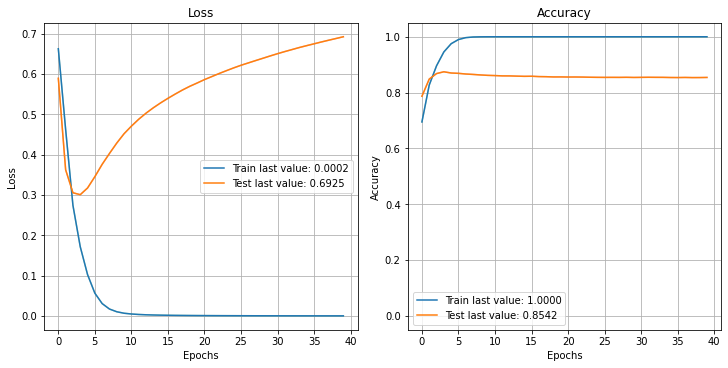

In [ ]:
# your code goes here

plot_history(history.history, path="standard.png")
plt.show()

Although adding layer here reduces the training loss, the evaluation accuracy is worse than the model without the extra convolutional layer.

Adding more layers can help you to extract more features. But we can do that up to a certain extent. After some point, instead of extracting features, we tend to overfit the data. Overfitting can lead to errors in on form or another, such as false positives. It is not easy to choose the number of units in a hidden layer or the number of hidden layers in a neural network. For many applications, one hidden layer is enough. As a general rule, the number of units in that hidden layer is between the number of inputs and the number of outputs.
 The best way to decide on the number of units and hidden layers is to try various parameters. Train several neural networks with different numbers of hidden layers and neurons, and monitor the performance of them. You will have to experiment using a series of different architectures. 







---

